# Plot Adsorption Isotherms

This notebook produces the isotherm plots that will go in the paper.

In [1]:
###
#  data_marker = Dict((xtal, simulation) => Dict(gas => kwargs...))
###

In [2]:
using PorousMaterials
using JLD2
using CSV
using DataFrames
using LinearAlgebra
using PyPlot
using PyCall
using Printf

PyPlot.matplotlib.style.use("ggplot")
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16;

┌ Warning: crystals path directory not found
│   path = /home/ng/NiPyC_analogues/visualizations/isotherm_plots/data/crystals
└ @ Xtals /home/ng/.julia/packages/Xtals/DSCSR/src/misc.jl:181
┌ Warning: data path directory not found
│   path = /home/ng/NiPyC_analogues/visualizations/isotherm_plots/data
└ @ Xtals /home/ng/.julia/packages/Xtals/DSCSR/src/misc.jl:181
┌ Warning: Error requiring `OffsetArrays` from `ArrayInterface`
│   exception = (UndefVarError(:IdOffsetRange), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007f10974d7cef, Ptr{Nothing} @0x00007f109756ad24, Ptr{Nothing} @0x00007f10892f5da2, Ptr{Nothing} @0x00007f109754d769, Ptr{Nothing} @0x00007f1097569f15, Ptr{Nothing} @0x00007f1097569bce, Ptr{Nothing} @0x00007f109756a811, Ptr{Nothing} @0x00007f109756b297, Base.InterpreterIP in top-level CodeInfo for ArrayInterface at statement 11, Ptr{Nothing} @0x00007f1097586b31, Ptr{Nothing} @0x00007f1097588949, Ptr{Nothing} @0x00007f1040225031, Ptr{Nothing} @0x00007f104022505c, 

In [3]:
# set_path_to_data(joinpath(pwd(), "../../data")) # old method
set_paths(joinpath(pwd(), "../../data"))

In [4]:
# what properties do you want to put into the .csv?
props_we_want = ["pressure (bar)", "fugacity (bar)", "⟨N⟩ (mmol/g)"]

adsorbates = ["Xe", "Kr", "Ar"]
molar_mass  = Dict("Xe" => 131.293, "Kr" => 83.798, "Ar" => 39.948) # g / mol

pmin  = -3 # minimum pessure in log10, units: bar
pmax  = 1.0 # maximum pressure (actual value), units: bar
nstep = 25 # number of intervals in pressure range

sim_params = Dict("adsorbates" => adsorbates,
                  "temp"       => 298.0, # units: K
                  "molecules"  => Dict(zip(adsorbates, Molecule.(adsorbates))),
                  "pressures"  => 10 .^ range(pmin, stop=log10(pmax), length=nstep),
                  "ljff"       => LJForceField("UFF"),
                  "n_burn"     => 50000,
                  "n_sample"   => 50000
                  )

Dict{String, Any} with 7 entries:
  "adsorbates" => ["Xe", "Kr", "Ar"]
  "ljff"       => Force field: UFF…
  "n_burn"     => 50000
  "pressures"  => [0.001, 0.00133352, 0.00177828, 0.00237137, 0.00316228, 0.004…
  "temp"       => 298.0
  "molecules"  => Dict{String, Molecule{Cart}}("Kr"=>Molecule species: Kr…
  "n_sample"   => 50000

## Data Retrieval Functions

#### Experimental

In [5]:
function experimental_isotherm_data(adsorbate::String, xtal_name::String, fgroup::String=""; 
                                    temp::Int64=298, ignore_des::Bool=true)
    # define data file name
    filename = xtal_name 
    if ! isempty(fgroup)
        filename *= "-" * fgroup
    end
    filename *= "_" * adsorbate * "_T_$(temp).csv"
#     @info filename
    
    # define path to data file
    wheres_exptl_data = joinpath(PorousMaterials.rc[:paths][:data],
        "experimental_isotherm_data", xtal_name, filename)
    
    # read data file into a DataFrame
    df_exptl_data = CSV.read(wheres_exptl_data, DataFrame)
    for col_name in names(df_exptl_data)
        if col_name == "PercentMass"
            # [(% mass) / 100 g Xe / g MOF](1 mol / MW_Xe g)
            factor = 1000.0 / molar_mass[adsorbate] / 100.0
            df_exptl_data[:, Symbol("loading (mmol/g)")] = factor * df_exptl_data[:, "PercentMass"]
        elseif col_name == "loading (ccSTP/g)"
            factor = 1 / 22.4 # (cc STP /g) (1000 g /kg) (1 mol/ 22.4 L STP) (1 L / 1000 cc)
            df_exptl_data[:, Symbol("loading (mmol/g)")] = factor * df_exptl_data[:, "loading (ccSTP/g)"]
        elseif col_name == "P(mbar)"
            df_exptl_data[!, Symbol("pressure (bar)")] = df_exptl_data[!, Symbol("P(mbar)")] / 1000
        end
    end
    # rename to adsorption column for consistency 
    rename!(df_exptl_data, Symbol("loading (mmol/g)") => Symbol("⟨N⟩ (mmol/g)"))
    
    # ignore desortion
    if ignore_des
        desorp_onset = argmax(df_exptl_data[!, Symbol("pressure (bar)")]) # onset of desorption
        df_exptl_data = df_exptl_data[1:desorp_onset, [Symbol("pressure (bar)"), Symbol("⟨N⟩ (mmol/g)")]]
    end
    
    # add a point at the origin
    push!(df_exptl_data, zeros(length(names(df_exptl_data))))
    
    # sort in order of increasing pressure
    if ignore_des
        sort!(df_exptl_data, Symbol("pressure (bar)"))
    end
    return df_exptl_data
end

experimental_isotherm_data (generic function with 2 methods)

#### Simulation

In [6]:
function read_sim_data(props::Array{String, 1}, xtal::Crystal, 
                        gas::Molecule{Cart}, temp::Float64, ljff::LJForceField, 
                        pressures::Array{Float64}, nburn::Int64, nsample::Int64)
    press = [[p] for p in pressures]
    df_sim = isotherm_sim_results_to_dataframe(props, xtal, [gas], temp, press, ljff, nburn, nsample)
    push!(df_sim, [[0.0], [0.0], [0.0]]) ### add point at origin ###
    sort!(df_sim, Symbol("pressure (bar)"))
    return df_sim
end

# create a second method that is easier to implement
function read_sim_data(props::Array{String, 1}, gas::String, params::Dict{String, Any})
    @assert (gas in params["adsorbates"])
    gas = Molecule(gas)
    return read_sim_data(props, params["xtal"], gas, params["temp"],
                         params["ljff"], params["pressures"], params["n_burn"], params["n_sample"])
end

###
#  account for change in unit cell volume when plotting adsorbates/unit_cell comparison
###
function adsorption_scale_factor(mof::String)
    xtal = Crystal(mof)
    strip_numbers_from_atom_labels!(xtal)
    ## conversion
    # N_A = 6.0221409e+23 atoms gas / mol gas
    # crystal density [ρ] = kg mof/m³
    # [xtal.box.Ω] = Å³ # Å = 1e-10 m
    # (10^(23) atoms gas / mol gas) * (kg mof / m³) * Å³ * (1e-30 m³ / Å³) = 
    #     1e-7 atoms gas * kg mof / mol gas
    adsorption_scale_factor = 6.02214 * crystal_density(xtal) * xtal.box.Ω * 10^(-7)
    return adsorption_scale_factor
end

adsorption_scale_factor (generic function with 1 method)

#### Henry Coeffient

In [7]:
# Calculate Henry Coefficients form experimental data
function henry_coeff(xtal_name::String, adsorbate::String, n_pts; fgroup::String="")
    # load experimental data
    data = experimental_isotherm_data(adsorbate, xtal_name, fgroup)
    params = fit_adsorption_isotherm(data[1:n_pts, :], Symbol("pressure (bar)"),
                                     Symbol("⟨N⟩ (mmol/g)"), :henry)
    return params # the Henry Coefficient
end

henry_coeff (generic function with 1 method)

## Dictionaries for Plotting 

In [8]:
adsorbate_to_color = Dict(zip(adsorbates, ["C0", "C1", "C2"]))

# adsorbate_to_marker = Dict(zip(["Xe", "Kr", "Ar"], ["v", "D", "h"]))


markers = ["o", "v", "^", ">", "<", "1", "2", "3", "4", "8", "s", "p", "P", 
            "*", "h", "H", "+", "x", "X", "D", "d", "."]


###
#  IDEA!! Make THIS A TUPLE: (Xe, sim) => "X", (Xe, exp) => "v"
data_marker = Dict(zip([1, 2, 3, 4, 5, 6],["X", "v", "P", "D", "*", "h"]))

# labels for each MOF
# mof_to_marker = Dict(zip(frameworks, ["x", "s", "P", "o", "*", ">"]))
# mof_to_color = Dict(zip(frameworks, ["C$i" for i = 1:length(frameworks)]))

# labels for each experimental data set
labels_exp = Dict("Xe" => "Xe experiment", 
                  "Kr" => "Kr experiment", 
                  "Ar" => "Ar experiment")

exp_data_to_marker = Dict(zip(["", "NH2"], ["v", "D"]))
exp_data_to_color  = Dict(zip(["", "NH2"], ["g", "b"]))

# labels for adsorbate used
labels_gas = Dict("Xe" => "Xe simulation",
                  "Kr" => "Kr simulation",
                  "Ar" => "Ar simulation")

pretty_names = Dict(("NiPyC2", "") => "Ni(PyC)" * L"_2", 
                    ("NiPyC2", "mNH2") => "Ni(PyC-" * L"m" * "-NH" * L"_2" * ")" * L"_2")

Dict{Tuple{String, String}, String} with 2 entries:
  ("NiPyC2", "")     => "Ni(PyC)\$_2\$"
  ("NiPyC2", "mNH2") => "Ni(PyC-\$m\$-NH\$_2\$)\$_2\$"

### Plot Henry Coefficient Fits

In [9]:
HK_pm = Dict{Tuple{String, String, String}, Dict{String, Float64}}()

mof="NiPyC2"; fgroup=""; 
HK_pm[(mof, fgroup, "Xe")] = henry_coeff(mof, "Xe", 2) # good ?
HK_pm[(mof, fgroup, "Kr")] = henry_coeff(mof, "Kr", 4) # good ?
HK_pm[(mof, fgroup, "Ar")] = henry_coeff(mof, "Ar", 4) # good ?

mof="NiPyC2"; fgroup="mNH2";
HK_pm[(mof, fgroup, "Xe")] = henry_coeff(mof, "Xe", 2; fgroup=fgroup) # good ?
HK_pm[(mof, fgroup, "Kr")] = henry_coeff(mof, "Kr", 4; fgroup=fgroup) # good ? 
HK_pm[(mof, fgroup, "Ar")] = henry_coeff(mof, "Ar", 4; fgroup=fgroup) # good ?

# HK_pm[("SBMOF-1", "", "Xe")] = henry_coeff_pm("SBMOF-1", "Xe", 9)
# HK_pm[("SBMOF-1", "", "Kr")] = henry_coeff_pm("SBMOF-1", "Kr", 6)

# n_pts[(mof[1], mof[2], gas)]

# for (i, mof) in enumerate([("NiPyC2", ""), ("NiPyC2", "mNH2"), ("SBMOF-1", "")])
#     for (j, gas) in enumerate(adsorbates)
#         # no data for this mof-gas pair
#         if mof[1] == "SBMOF-1" && gas == "Ar"
#             continue
#         end
#         HK_pm[(mof[1], mof[2], gas)] = henry_coeff(mof[1], gas, n_pts[(mof[1], mof[2], gas)]; fgroup=mof[2])
#     end
# end

HK_pm

Dict{Tuple{String, String, String}, Dict{String, Float64}} with 6 entries:
  ("NiPyC2", "mNH2", "Kr") => Dict("MSE"=>3.82031e-8, "H"=>4.85344)
  ("NiPyC2", "mNH2", "Xe") => Dict("MSE"=>1.54074e-33, "H"=>98.2455)
  ("NiPyC2", "", "Xe")     => Dict("MSE"=>0.0, "H"=>53.7781)
  ("NiPyC2", "", "Ar")     => Dict("MSE"=>7.51689e-9, "H"=>0.445962)
  ("NiPyC2", "mNH2", "Ar") => Dict("MSE"=>1.04675e-8, "H"=>0.547776)
  ("NiPyC2", "", "Kr")     => Dict("MSE"=>6.05053e-9, "H"=>3.14382)

In [10]:
# selectivity
selectivity  = Dict{Tuple{String, String, String, String}, Float64}()
for key in keys(HK_pm)
    for gas in adsorbates
        if key[3] != gas
            selectivity[(key[1], key[2], key[3], gas)] = HK_pm[key]["H"] / HK_pm[(key[1], key[2], gas)]["H"]
        end
    end
end
selectivity

Dict{NTuple{4, String}, Float64} with 12 entries:
  ("NiPyC2", "", "Ar", "Xe")     => 0.00829264
  ("NiPyC2", "mNH2", "Xe", "Kr") => 20.2424
  ("NiPyC2", "mNH2", "Ar", "Kr") => 0.112863
  ("NiPyC2", "", "Kr", "Xe")     => 0.0584591
  ("NiPyC2", "", "Kr", "Ar")     => 7.04951
  ("NiPyC2", "", "Xe", "Ar")     => 120.589
  ("NiPyC2", "mNH2", "Kr", "Xe") => 0.0494012
  ("NiPyC2", "mNH2", "Ar", "Xe") => 0.00557558
  ("NiPyC2", "mNH2", "Xe", "Ar") => 179.353
  ("NiPyC2", "", "Ar", "Kr")     => 0.141854
  ("NiPyC2", "mNH2", "Kr", "Ar") => 8.86027
  ("NiPyC2", "", "Xe", "Kr")     => 17.106

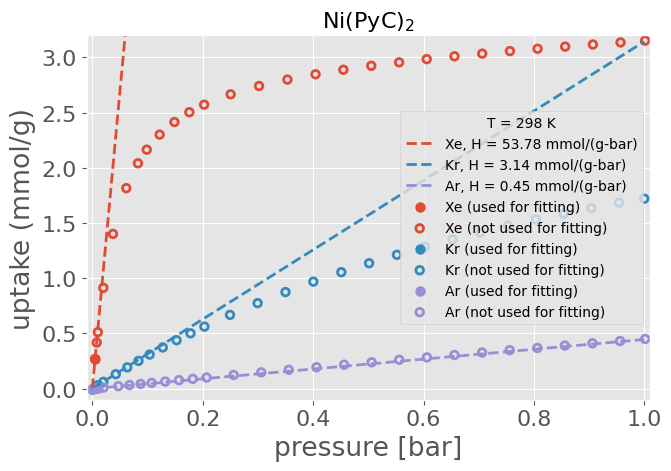

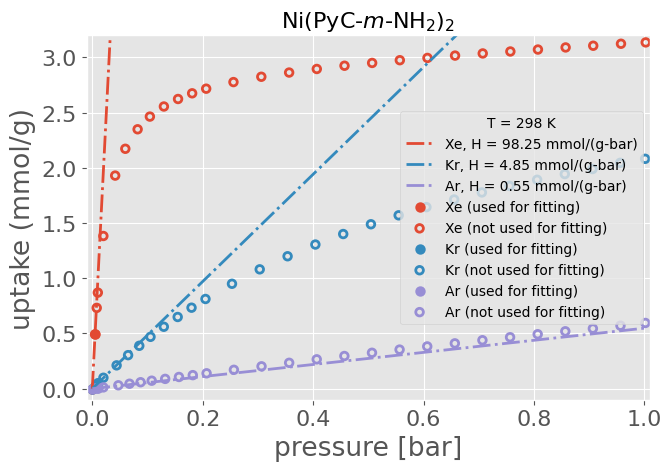

In [11]:
# dict for num points and axes lims
plt_data = Dict(
    # parent mof
    ("NiPyC2", "", "Xe")     => Dict("n_pts" => 2, "xlims" => [-1E-4, 0.006], "ylims" => [-0.01, 0.6]),
    ("NiPyC2", "", "Kr")     => Dict("n_pts" => 4, "xlims" => [-1E-4, 0.011], "ylims" => [-1E-3, 0.06]),
    ("NiPyC2", "", "Ar")     => Dict("n_pts" => 4, "xlims" => [-1E-4, 0.012], "ylims" => [-1E-4, 0.008]),
    # functionalized mof
    ("NiPyC2", "mNH2", "Xe") => Dict("n_pts" => 2, "xlims" => [-1E-4, 0.006], "ylims" => [-0.01, 0.6]),
    ("NiPyC2", "mNH2", "Kr") => Dict("n_pts" => 4, "xlims" => [-1E-4, 0.011], "ylims" => [-1E-3, 0.06]),
    ("NiPyC2", "mNH2", "Ar") => Dict("n_pts" => 4, "xlims" => [-1E-4, 0.012], "ylims" => [-1E-4, 0.008])
)

mof_to_marker = Dict(("NiPyC2", "") => "v", ("NiPyC2", "mNH2") => "p")
mof_linetype  = Dict(("NiPyC2", "") => "--", ("NiPyC2", "mNH2") => "-.")

for mof in [("NiPyC2", ""), ("NiPyC2", "mNH2")]
    figure(figsize=(7, 5)) # figsize=(12, 6), generate a figure
    for gas in adsorbates
        # load experimental data
        data = experimental_isotherm_data(gas, mof[1], mof[2])
        
        # plot Henry fit
        p = range(0, stop=1.0, length=100)
        n = HK_pm[(mof[1], mof[2], gas)]["H"] .* p
        str = @sprintf("%0.2f mmol/(g-bar)", HK_pm[(mof[1], mof[2], gas)]["H"])
        plot(p, n, label=gas * ", H = " * str, 
            linestyle=mof_linetype[mof], linewidth=2,
            color=adsorbate_to_color[gas])
        
        # plot points used in fitting
        scatter(data[1:plt_data[(mof[1], mof[2], gas)]["n_pts"], Symbol("pressure (bar)")], 
                         data[1:plt_data[(mof[1], mof[2], gas)]["n_pts"], Symbol("⟨N⟩ (mmol/g)")],
                         s=30,
                         label=gas* " (used for fitting)",
                         color=adsorbate_to_color[gas],
                         linewidth=2)
        
        # plot points not used in fitting
        scatter(data[plt_data[(mof[1], mof[2], gas)]["n_pts"]:end, Symbol("pressure (bar)")], 
                         data[plt_data[(mof[1], mof[2], gas)]["n_pts"]:end, Symbol("⟨N⟩ (mmol/g)")],
                         s=30,
                         label=gas* " (not used for fitting)", 
                         facecolor="none", 
                         edgecolor=adsorbate_to_color[gas],
                         linewidth=2)
        
        legend(title="T = 298 K", title_fontsize=10, 
               fontsize=10,  loc=7)

        title(pretty_names[(mof[1], mof[2])], fontsize=16)
        
        xlim([-0.01, 1.01])
        ylim([-0.1, 3.2])
        
        xlabel("pressure [bar]")
        ylabel("uptake (mmol/g)")
        tight_layout()
    end
    filename = "henry_isotherm_fit_$(mof[1])"
    isempty(mof[2]) ? filename *= "" : filename *= "-$(mof[2])"
#     savefig(joinpath(pwd(), "henry_coeff", filename * ".pdf"), dpi=600, format="pdf")
end

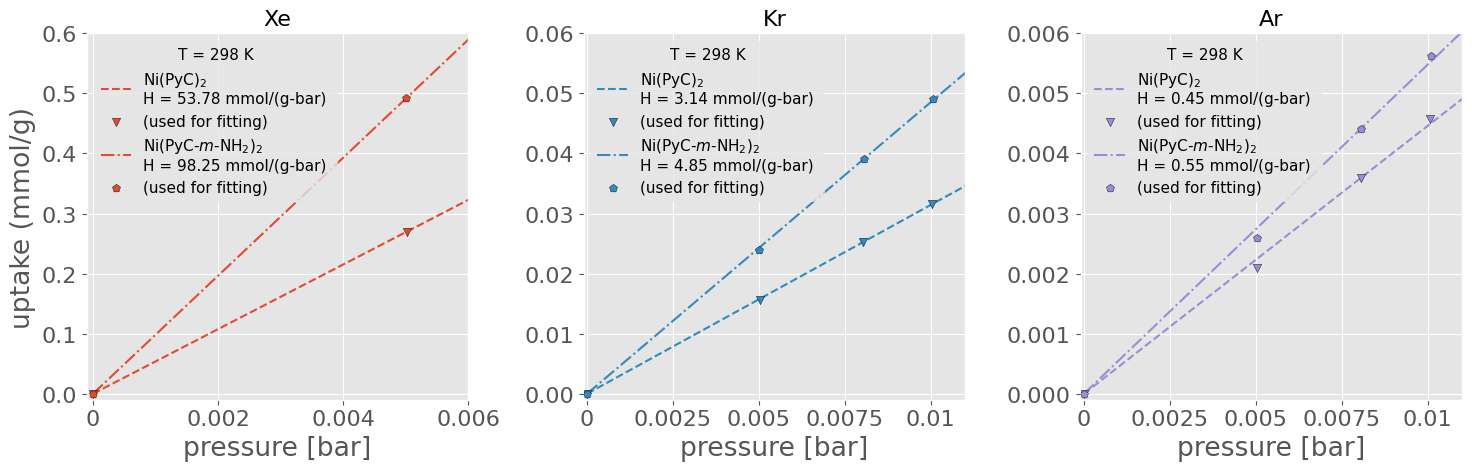

"henry_fit_multi-panel"

In [12]:
# dict for num points and one for ylims
# look at Xe/Kr, Xe/Ar, Kr/Ar
plt_data = Dict(
    # parent mof
    ("NiPyC2", "", "Xe")     => Dict("n_pts" => 2, "xlims" => [-1E-4, 0.006], "ylims" => [-0.01, 0.6]),
    ("NiPyC2", "", "Kr")     => Dict("n_pts" => 4, "xlims" => [-1E-4, 0.011], "ylims" => [-1E-3, 0.06]),
    ("NiPyC2", "", "Ar")     => Dict("n_pts" => 4, "xlims" => [-1E-4, 0.011], "ylims" => [-1E-4, 0.006]),
    # functionalized mof
    ("NiPyC2", "mNH2", "Xe") => Dict("n_pts" => 2, "xlims" => [-1E-4, 0.006], "ylims" => [-0.01, 0.6]),
    ("NiPyC2", "mNH2", "Kr") => Dict("n_pts" => 4, "xlims" => [-1E-4, 0.011], "ylims" => [-1E-3, 0.06]),
    ("NiPyC2", "mNH2", "Ar") => Dict("n_pts" => 4, "xlims" => [-1E-4, 0.011], "ylims" => [-1E-4, 0.006])
)


fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for (ind, gas) in enumerate(adsorbates)
    for mof in [("NiPyC2", ""), ("NiPyC2", "mNH2")]
        # load experimental data
        data = experimental_isotherm_data(gas, mof[1], mof[2])
        # format coeff as string to print in/on plots
        str = @sprintf("%0.2f mmol/(g-bar) ", HK_pm[(mof[1], mof[2], gas)]["H"])
        
        # plot Henry fit
        p = range(0, stop=1.0, length=100)
        n = HK_pm[(mof[1], mof[2], gas)]["H"] .* p
        axs[ind].plot(p, n, 
                      label=pretty_names[mof] * "\nH = " * str, 
                      linestyle=mof_linetype[mof],
                      color=adsorbate_to_color[gas])

        # print Henry coefficient on plot
#         bbox_kwargs = Dict(:facecolor => "none", :edgecolor => "k", :boxstyle => "round")
#         axs[ind].text(0.001, data[plt_data[(mof[1], mof[2], gas)]["n_pts"], Symbol("⟨N⟩ (mmol/g)")], 
#                          str, fontsize="x-small", bbox=bbox_kwargs)

        # plot points used in fitting
        axs[ind].scatter(data[1:plt_data[(mof[1], mof[2], gas)]["n_pts"], Symbol("pressure (bar)")], 
                         data[1:plt_data[(mof[1], mof[2], gas)]["n_pts"], Symbol("⟨N⟩ (mmol/g)")],
                         label="(used for fitting)",
                         marker=mof_to_marker[mof],
                         color=adsorbate_to_color[gas],
                         edgecolor="k", linewidth=0.3, Zorder=10)
        # plot points not used in fitting
#         axs[ind].scatter(data[plt_data[(mof[1], mof[2], gas)]["n_pts"]:end, Symbol("pressure (bar)")], 
#                          data[plt_data[(mof[1], mof[2], gas)]["n_pts"]:end, Symbol("⟨N⟩ (mmol/g)")],
# #                          label=gas* " (not used for fitting)",
#                          marker = mof_to_marker[mof],
#                          facecolor="none", 
#                          edgecolor=adsorbate_to_color[gas],
#                          linewidth=1.2)

        axs[ind].set_xlim(plt_data[mof[1], mof[2], gas]["xlims"])
        axs[ind].set_ylim(plt_data[mof[1], mof[2], gas]["ylims"])
        axs[ind].xaxis.set_major_formatter("{x:,g}") 
    end
        handles, labels = axs[ind].get_legend_handles_labels()
        order = [1, 3, 2, 4]    
        axs[ind].legend([handles[idx] for idx in order], 
                    [labels[idx] for idx in order],
                    title="T = 298 K", title_fontsize=11,
                    fontsize=11, loc="best", edgecolor="none")

        axs[ind].set_xlabel("pressure [bar]")
        axs[1].set_ylabel("uptake (mmol/g)")
        axs[ind].set_title(gas, fontsize=16)
        tight_layout()
end

filename = "henry_fit_multi-panel"
# savefig(joinpath(pwd(), "henry_coeff", filename * ".pdf"), dpi=600, format="pdf")

### Ni(PyC)2 adsorption isotherm plot

┌ Info: Crystal NiPyC2_experiment.cif has Pn space group. I am converting it to P1 symmetry.
│         To prevent this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ Xtals /home/ng/.julia/packages/Xtals/DSCSR/src/crystal.jl:433
┌ Info: Crystal NiPyC2_experiment.cif has Pn space group. I am converting it to P1 symmetry.
│         To prevent this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ Xtals /home/ng/.julia/packages/Xtals/DSCSR/src/crystal.jl:433


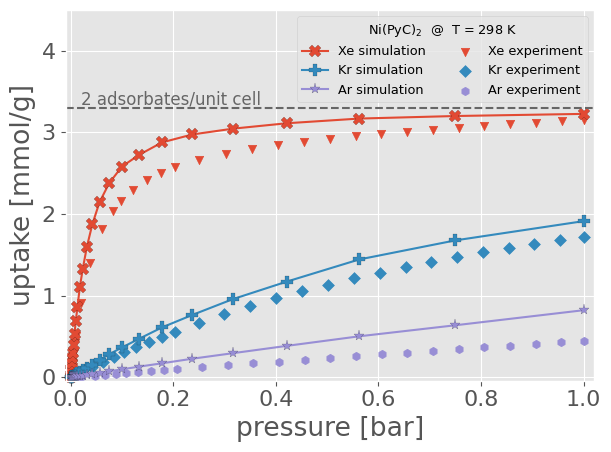

┌ Info: 0.6057925098568889
└ @ Main In[13]:76


In [13]:
# frameworks to plot
frameworks = ["NiPyC2_experiment.cif"]
labels_mof = Dict(zip(frameworks, ["Ni(PyC)"*L"_2"]))

###
# Create Figure
###
fig, ax1 = plt.subplots() # create the figure as a subplot

# create an array for plot handles
plts = Array{Any, 1}(undef, 6)
nn = 0 # plot index

# create an empty plot object to place T=298 K in legend
# plts[nn] = ax1.scatter([], [], label="T = 298 K", marker=data_marker[nn], color="")


########
sim_params["xtal"] = Crystal(frameworks[1])

for gas in adsorbates
    for mof in frameworks
        # increment plot index
        nn += 1 

        # load in simulation data
        df_sim = read_sim_data(props_we_want, gas, sim_params)
        
        # plot uptake mmol/g 
        plts[nn] = ax1.plot(df_sim[:, Symbol("pressure (bar)")], 
                            df_sim[:, Symbol("⟨N⟩ (mmol/g)")], 
                            label=labels_gas[gas],
                            marker=data_marker[nn],
                            markersize=8,
                            markeredgecolor="black",
                            markeredgewidth=0.1,
                            color=adsorbate_to_color[gas],
                            clip_on=false)
    end
    # increment plot index
    nn += 1 
    
    # reset ads_scale_factor
    ads_scale_factor = 1.0 
    
    # load exptl data
    df_exp = experimental_isotherm_data(gas, mof) # default fgroup=""
    # plot exptl data
    plts[nn] = ax1.scatter(df_exp[:, Symbol("pressure (bar)")], 
                            df_exp[:, Symbol("⟨N⟩ (mmol/g)")], 
                            label=labels_exp[gas],
                            marker=data_marker[nn],
                            color=adsorbate_to_color[gas],
                            clip_on=false)
end

# title("Ni(PyC)" * L"$_2$" * " simulation vs. experiment")
legend(loc="upper right", fontsize="xx-small",
       title="Ni(PyC)" * L"$_2$" * "  @  T = 298 K", 
       title_fontsize="xx-small", ncol=2)

ax1.grid("on")
ax1.set_xlabel("pressure [bar]")
ax1.set_ylabel("uptake [mmol/g]")

ymin = -0.04
ymax = 4.5
ax1.set_ylim(ymin, ymax)

xmin = -0.01
xmax = sim_params["pressures"][end] + 0.02
ax1.set_xlim(xmin, xmax)

# plot commenerate adsorption line
ads_scale_factor = adsorption_scale_factor(frameworks[1])
@info ads_scale_factor
ax1.axhline(y=2/ads_scale_factor, linestyle="--", color="0.4")
ax1.text(0.02, 2/ads_scale_factor+0.04, "2 adsorbates/unit cell", color="0.4", fontsize=12) # fontsize=9

tight_layout()
# savefig("NiPyC2_isotherms_sim_vs_exp_UFF.png", dpi=600, format="png")
savefig("NiPyC2_isotherms_sim_vs_exp_UFF.pdf", dpi=600, format="pdf")

### Ni(PyC-m-NH2)2 Adsorption Isotherm Plot

┌ Info: Crystal Pn_Ni-PyC-NH2.cif has Pn space group. I am converting it to P1 symmetry.
│         To prevent this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ Xtals /home/ng/.julia/packages/Xtals/DSCSR/src/crystal.jl:433
┌ Info: Crystal Pn_Ni-PyC-NH2.cif has Pn space group. I am converting it to P1 symmetry.
│         To prevent this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ Xtals /home/ng/.julia/packages/Xtals/DSCSR/src/crystal.jl:433


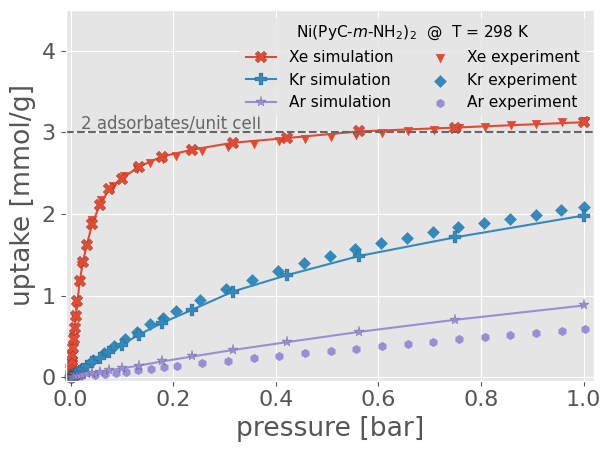

┌ Info: 0.6658510569544414
└ @ Main In[14]:72


In [14]:
# frameworks to plot
frameworks = ["Pn_Ni-PyC-NH2.cif"] #["NiPyC2_relax_sc211_meta_functionalized_NH2_pbesol_relax.cif"]

sim_params["xtal"] = Crystal(frameworks[1])

labels_mof = Dict(zip(frameworks, ["Ni(PyC-" * L"m" * "-NH" * L"_2" * ")" * L"_2"]))

###
# Create Figure
###
fig, ax1 = plt.subplots() # create the figure as a subplot

# create an array for plot handles
plts = Array{Any, 1}(undef, 6)
nn   = 0 # plot index

# sim_params

for gas in adsorbates
    for mof in frameworks
        # increment plot index
        nn += 1 

        # load in simulation data
        df_sim = read_sim_data(props_we_want, gas, sim_params)
        
        # plot uptake mmol/g 
        plts[nn] = ax1.plot(df_sim[:, Symbol("pressure (bar)")], 
                            df_sim[:, Symbol("⟨N⟩ (mmol/g)")], 
                            label=labels_gas[gas],
                            marker=data_marker[nn],
                            markersize=8,
                            markeredgecolor="black",
                            markeredgewidth=0.1,
                            color=adsorbate_to_color[gas],
                            clip_on=false)
    end
    # increment plot index
    nn += 1 
    
    # load exptl data
    df_exp = experimental_isotherm_data(gas, mof, "mNH2") # default fgroup=""
    # plot exptl data
    plts[nn] = ax1.scatter(df_exp[:, Symbol("pressure (bar)")], 
                            df_exp[:, Symbol("⟨N⟩ (mmol/g)")], 
                            label=labels_exp[gas],
                            marker=data_marker[nn],
                            color=adsorbate_to_color[gas],
                            clip_on=false)
end

# title("Ni(PyC-" * L"m" * "-NH" * L"_2" * ")" * L"_2", fontsize="xx-small")
legend(loc="best", fontsize="x-small",
       title="Ni(PyC-" * L"m" * "-NH" * L"_2" * ")" * L"_2" *"  @  T = 298 K",
       title_fontsize="x-small", ncol=2, edgecolor="none")

ax1.grid("on")
ax1.set_xlabel("pressure [bar]")
ax1.set_ylabel("uptake [mmol/g]")

ymin = -0.04
ymax = 4.5
ax1.set_ylim(ymin, ymax)


xmin = -0.01
xmax = sim_params["pressures"][end] + 0.02
ax1.set_xlim(xmin, xmax)

# plot commencerate adsorption line
ads_scale_factor = adsorption_scale_factor(frameworks[1])
@info ads_scale_factor
ax1.axhline(y=2/ads_scale_factor, linestyle="--", color="0.4")
ax1.text(0.02, 2/ads_scale_factor+0.04, "2 adsorbates/unit cell", color="0.4", fontsize=12) # fontsize=9

tight_layout()
# savefig("mNH2-NiPyC2_isotherms_sim_vs_exp_UFF.png", dpi=360, format="png")
savefig("mNH2-NiPyC2_isotherms_exp_UFF.pdf", dpi=600, format="pdf")

#### Single Net Ni(PyC-m-NH2)2 Adsorption Isotherm Plot

In [15]:
data_marker = Dict(zip([1, 2, 3], ["v", "X", "p"]))

net_type = ["doubble net", "single net"]
# net_type = ["Pn", "P21"]

# frameworks to plot
frameworks = ["NiPyC2_relax_sc211_meta_functionalized_NH2_pbesol_relax.cif",
              "NiPyC2_relax_sc211_meta_functionalized_NH2_pbesol_relax_comp1.cif"]
# frameworks = ["Pn_Ni-PyC-NH2.cif", "P21-n_Ni-PyC-NH2.cif"]

crystals = Crystal.(frameworks, remove_duplicates=true)

labels_mof = Dict(zip(frameworks, 
                  ["Ni(PyC-" * L"m" * "-NH" * L"_2" * ")" * L"_2", 
                   "Ni(PyC-" * L"m" * "-NH" * L"_2" * ")" * L"_2"]))

###
# Create Figure
###
fig, ax1 = plt.subplots() # create the figure as a subplot

# create an array for plot handles
plts = Array{Any, 1}(undef, 6)
nn   = 0 # plot index

for gas in ["Xe"]
    # increment plot index
    nn += 1 
    
    # load exptl data
    df_exp = experimental_isotherm_data(gas, mof, "mNH2") # default fgroup=""
    # plot exptl data
    plts[nn] = ax1.scatter(df_exp[:, Symbol("pressure (bar)")], 
                            df_exp[:, Symbol("⟨N⟩ (mmol/g)")], 
                            label=labels_exp[gas],
                            marker=data_marker[nn],
                            color="k",
                            clip_on=false)
    
    for (i, mof) in enumerate(crystals)
        # increment plot index
        nn += 1
        
        # needed to get isothem data
        sim_params["xtal"] = mof
        
        # load in simulation data
        df_sim = read_sim_data(props_we_want, gas, sim_params)
        
        # plot uptake mmol/g 
        plts[nn] = ax1.plot(df_sim[:, Symbol("pressure (bar)")], 
                            df_sim[:, Symbol("⟨N⟩ (mmol/g)")], 
                            label=labels_gas[gas] * net_type[i],
                            marker=data_marker[nn],
                            markersize=8,
                            markeredgecolor="black",
                            markeredgewidth=0.2,
                            color=adsorbate_to_color[gas],
                            clip_on=false)
    end
end

# title("Single Net Ni(PyC-" * L"m" * "-NH" * L"_2" * ")" * L"_2", fontsize="xx-small")


legend(title="T = 298 K", title_fontsize="xx-small",
        (plts[1], plts[2][1], plts[3][1]),
        ["experiment", "simulation, double-net", "simulation, single-net"],
        loc="lower right", fontsize="xx-small")

ax1.grid("on")
ax1.set_xlabel("pressure [bar]")
ax1.set_ylabel("Xe uptake [mmol/g]")

ymin = -0.04
ymax = 3.5
ax1.set_ylim(ymin, ymax)


xmin = -0.01
xmax = sim_params["pressures"][end] + 0.01
ax1.set_xlim(xmin, xmax)

tight_layout()
# savefig("Single_Net_mNH2-NiPyC2_isotherms_sim_vs_exp_UFF.png", dpi=600, format="png")
# savefig("Single_Net_mNH2-NiPyC2_isotherms_sim_vs_exp_UFF.pdf", dpi=600, format="pdf")

LoadError: SystemError: opening file "/home/ng/NiPyC_analogues/visualizations/isotherm_plots/../../data/crystals/NiPyC2_relax_sc211_meta_functionalized_NH2_pbesol_relax.cif": No such file or directory

### Compare Ni(PyC)2 isotherms to DFT relaxed isotherms 

In [16]:
frameworks = ["NiPyC2_experiment.cif", 
              "NiPyC2_relax.cif",
              "NiPyC2_vc-relax.cif", 
              "NiPyC2_pbesol-angle-vc-relax.cif"]

xtals = [Crystal(f) for f in frameworks]
[strip_numbers_from_atom_labels!(xtals[i]) for i in 1:length(xtals)]

labels_mof = Dict(zip(xtals, ["Parent MOF", 
                              "relax",
                              "vc-relax", 
                              "angle-vc-relax"]))

mof_to_marker = Dict(zip(xtals, ["P", "2", "x", "o", "*", ">"]))
mof_to_color  = Dict(zip(xtals, ["C1", "C2", "C3", "C4"]))

adsorption_per_unit_cell = false
ads_scale_factor = 1.0

if adsorption_per_unit_cell
    ads_scale_factor = adsorption_scale_factor(frameworks[1])
    xtal = Crystal(frameworks[1])
    strip_numbers_from_atom_labels!(xtal)
#     @assert length(frameworks) == 1
#     adsorption_scale_factor = 6.02214 * crystal_density(xtal) * xtal.box.Ω * 10^(-7)
end


###
# make figure
###
figure()
for gas in ["Xe"]
    for mof in xtals
        sim_params["xtal"] = mof
        df_sim = read_sim_data(props_we_want, gas, sim_params)
        plot(df_sim[:, Symbol("pressure (bar)")], 
                df_sim[:, Symbol("⟨N⟩ (mmol/g)")] * ads_scale_factor, 
                label="simulation, " * labels_mof[mof], 
                marker=mof_to_marker[mof],
                color=mof_to_color[mof])
    end
    
    df_exp = experimental_isotherm_data(gas, mof)
    scatter(df_exp[:, Symbol("pressure (bar)")], 
            df_exp[:, Symbol("⟨N⟩ (mmol/g)")] * ads_scale_factor, 
            label= "experiment, " * "Parent MOF", 
            marker="v", 
            color="C0")
end

legend(loc="best", fontsize="x-small", 
       title="Ni(PyC)" * L"$_2$" * "  @  T = 298 K",
       title_fontsize="x-small")

# axis bounds
xmin = -0.01
xmax = sim_params["pressures"][end] + 0.01
xlim(xmin, xmax)
ymin = -0.04
ymax = 4
ylim(ymin, ymax)
# labels
xlabel("pressure [bar]")
if adsorption_per_unit_cell
    ylabel("uptake [atoms/unit cell]")
else
    ylabel("Xe uptake [mmol/g]")
end

grid("on")
tight_layout()
# savefig("NiPyC2_DFT_isotherms_with_UFF.png", dpi=600, format="png")
# savefig("NiPyC2_DFT_isotherms_with_UFF.pdf", dpi=600, format="pdf")
# savefig("NiPyC2_isotherms_uptake_per_unit_cell_with_$ffield.pdf", dpi=600, format="pdf")

┌ Info: Crystal NiPyC2_experiment.cif has Pn space group. I am converting it to P1 symmetry.
│         To prevent this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ Xtals /home/ng/.julia/packages/Xtals/DSCSR/src/crystal.jl:433


LoadError: SystemError: opening file "/home/ng/NiPyC_analogues/visualizations/isotherm_plots/../../data/crystals/NiPyC2_vc-relax.cif": No such file or directory

## Plot simulated isotherm of experimental m-NH2 against its experimental data

In [17]:
# data_marker = Dict(zip([1, 2, 3], ["v", "D", "h"]))
data_marker = Dict(zip([1, 2, 3, 4, 5, 6, 7, 8, 9], 
                       ["v", "X", "D", "P", "h", "*", "o", "^", "s"]))

# symm_type = [" Pn", " P21"]

# frameworks to plot
# frameworks = ["Pn_Ni-PyC-NH2.cif", "P21-n_Ni-PyC-NH2.cif""]
frameworks = ["Pn_Ni-PyC-NH2.cif",
              "NiPyC2_relax_sc211_meta_functionalized_NH2_pbesol_relax.cif"]


crystals = Crystal.(frameworks, remove_duplicates=true)

# labels_mof = Dict(zip(frameworks, 
#                   ["Ni(PyC-" * L"m" * "-NH" * L"_2" * ")" * L"_2", 
#                    "Ni(PyC-" * L"m" * "-NH" * L"_2" * ")" * L"_2"]))

isotherm_type = Dict(zip(crystals, [" (experimental structure)", " (predicted structure)"]))

###
# Create Figure
###
fig, axs = plt.subplots(figsize=(9, 5)) # create the figure as a subplot

# create an array for plot handles
plts = Array{Any, 1}(undef, 9)
nn = 0 # plot index

for gas in adsorbates # ["Xe"]
    nn += 1
    # load exptl data
    df_exp = experimental_isotherm_data(gas, mof, "mNH2") # default fgroup=""
    # plot exptl data
    axs.scatter(df_exp[:, Symbol("pressure (bar)")], 
                df_exp[:, Symbol("⟨N⟩ (mmol/g)")],
#                             s=50,
                label=gas * " experiment",
                marker=data_marker[nn],
                edgecolor=adsorbate_to_color[gas],
                color=adsorbate_to_color[gas],
                clip_on=false)

    for (i, mof) in enumerate(crystals)
    # increment plot index
    nn += 1

    # needed to get isothem data
    sim_params["xtal"] = mof

    # load in simulation data
    df_sim = read_sim_data(props_we_want, gas, sim_params)

    # plot uptake mmol/g 
    axs.plot(df_sim[:, Symbol("pressure (bar)")], 
                df_sim[:, Symbol("⟨N⟩ (mmol/g)")], 
                label=gas * isotherm_type[mof],
                marker=data_marker[nn],
                markersize=8,
                markeredgecolor="k",
                markeredgewidth=0.2,
                color=adsorbate_to_color[gas],
                clip_on=false, zorder=10)
    end
end
# "Ni(PyC-" * L"m" * "-NH" * L"_2" * ")" * L"_2" 
axs.legend(title="T = 298 K", 
           title_fontsize="xx-small", fontsize="xx-small",
           bbox_to_anchor=(1.05, 1))

axs.grid("on")
axs.set_xlabel("pressure [bar]")
axs.set_ylabel("uptake [mmol/g]")

ymin = -0.04
ymax = 3.5
axs.set_ylim(ymin, ymax)

xmin = -0.01
xmax = sim_params["pressures"][end] + 0.01
axs.set_xlim(xmin, xmax)

# divided by two to account for 2x1x1 cell replication before DFT relaxation
ads_scale_factor = adsorption_scale_factor("Pn_Ni-PyC-NH2.cif")
@info ads_scale_factor
axs.axhline(y=2/ads_scale_factor, linestyle="--", color="0.4")
axs.text(0.02, 2/ads_scale_factor+0.04, "2 adsorbates/unit cell", color="0.4", fontsize=9)

tight_layout()
# savefig("mNH2-NiPyC2_isotherms_exptl_vs_sim_vs_predicted_UFF.png", dpi=600, format="png")
# savefig("mNH2-NiPyC2_isotherms_exptl_vs_sim_vs_predicted_UFF.pdf", dpi=600, format="pdf")

┌ Info: Crystal Pn_Ni-PyC-NH2.cif has Pn space group. I am converting it to P1 symmetry.
│         To prevent this, pass `convert_to_p1=false` to the `Crystal` constructor.
└ @ Xtals /home/ng/.julia/packages/Xtals/DSCSR/src/crystal.jl:433


LoadError: SystemError: opening file "/home/ng/NiPyC_analogues/visualizations/isotherm_plots/../../data/crystals/NiPyC2_relax_sc211_meta_functionalized_NH2_pbesol_relax.cif": No such file or directory

# isotherms at different temperatures

plot the T = 298 K, 288 K, and 278 K for both the parent and mNH2 MOF
- consider doing a multi-pannel (2 x 3) with adsorbates on columns and MOFs on the rows then 3 temps per plot.

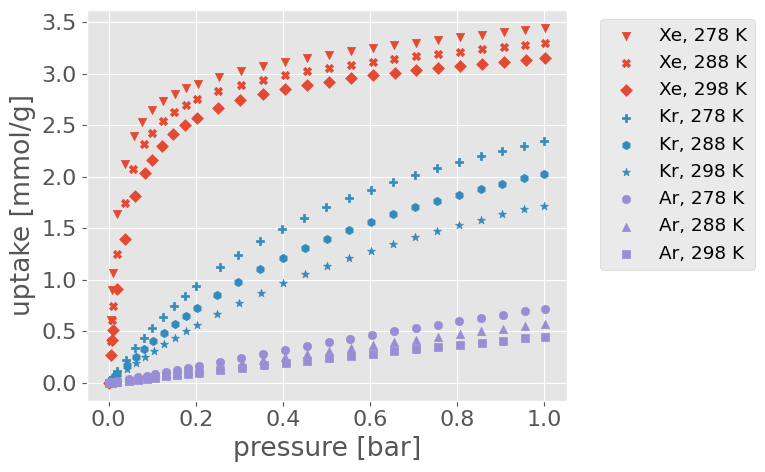

In [18]:
temperatures = Dict(278 => "278", 288 => "288", 298 => "298")
data_markers = ["v", "X", "D", "P", "h", "*", "o", "^", "s"]

figure(figsize=(8, 5))
n = 0
for gas in adsorbates
    for t in [278, 288, 298]
        n += 1
        df_parent = experimental_isotherm_data(gas, "NiPyC2"; temp=t)
        scatter(df_parent[!, Symbol("pressure (bar)")], 
                df_parent[!, Symbol("⟨N⟩ (mmol/g)")],
                label=gas * ", " * temperatures[t] * " K", 
                marker=data_markers[n],
                color=adsorbate_to_color[gas])  
    end
end

legend(fontsize="small", bbox_to_anchor=(1.05, 1))

grid("on")
xlabel("pressure [bar]")
ylabel("uptake [mmol/g]")

tight_layout()
# savefig("multi-temperature_experimental_isotherms_plot.pdf", dpi=600, format="pdf")

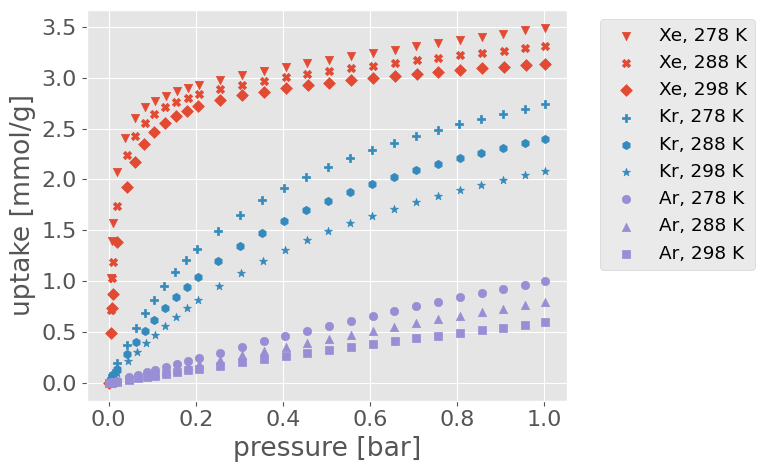

In [19]:
temperatures = Dict(278 => "278", 288 => "288", 298 => "298")
data_markers = ["v", "X", "D", "P", "h", "*", "o", "^", "s"]

figure(figsize=(8, 5))
n = 0
for gas in adsorbates
    for t in [278, 288, 298]
        n += 1
        df_parent = experimental_isotherm_data(gas, "NiPyC2", "mNH2"; temp=t)
        scatter(df_parent[!, Symbol("pressure (bar)")], 
                df_parent[!, Symbol("⟨N⟩ (mmol/g)")],
                label=gas * ", " * temperatures[t] * " K", 
                marker=data_markers[n],
                color=adsorbate_to_color[gas])  
    end
end

legend(fontsize="small", bbox_to_anchor=(1.05, 1))

grid("on")
xlabel("pressure [bar]")
ylabel("uptake [mmol/g]")

tight_layout()
# savefig("NH2_multi-temperature_experimental_isotherms_plot.pdf", dpi=600, format="pdf")

## N2 isotherm for BET surface area calculation

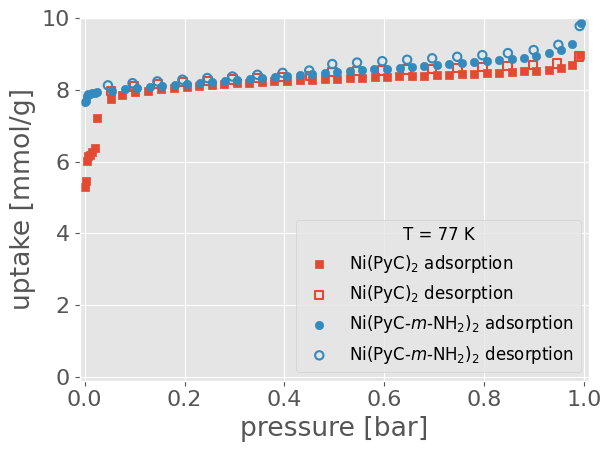

In [20]:
# load N2 data
parent_n2 = experimental_isotherm_data("N2", "NiPyC2"; temp=77, ignore_des=false)
mnh2_n2   = experimental_isotherm_data("N2", "NiPyC2", "mNH2"; temp=77, ignore_des=false)
# find onset of desorption
desorp_onset_parent = argmax(parent_n2[!, Symbol("pressure (bar)")]) # onset of desorption
desorp_onset_mNH2   = argmax(parent_n2[!, Symbol("pressure (bar)")]) # onset of desorption

# make figure
figure()
scatter(parent_n2[1:desorp_onset_parent, Symbol("pressure (bar)")], 
        parent_n2[1:desorp_onset_parent, Symbol("⟨N⟩ (mmol/g)")],
        label=pretty_names[("NiPyC2", "")] * " adsorption",
        color="C0", marker="s")

scatter(parent_n2[desorp_onset_parent + 1 : end - 1, Symbol("pressure (bar)")], 
        parent_n2[desorp_onset_parent + 1 : end - 1, Symbol("⟨N⟩ (mmol/g)")],
        label=pretty_names[("NiPyC2", "")] * " desorption",
        color="C0", marker="s", facecolor="none", lw=1.5)

scatter(mnh2_n2[1:desorp_onset_mNH2, Symbol("pressure (bar)")], 
        mnh2_n2[1:desorp_onset_mNH2, Symbol("⟨N⟩ (mmol/g)")],
        label=pretty_names[("NiPyC2", "mNH2")] * " adsorption",
        color="C1", marker="o")

scatter(mnh2_n2[desorp_onset_mNH2 + 1 : end - 1, Symbol("pressure (bar)")], 
        mnh2_n2[desorp_onset_mNH2 + 1 : end - 1, Symbol("⟨N⟩ (mmol/g)")],
        label=pretty_names[("NiPyC2", "mNH2")] * " desorption",
        color="C1", marker="o", facecolor="none", lw=1.5)

ylim([-0.1, 10])
xlim([-0.01, 1.01])

legend(title="T = 77 K", loc="lower right", fontsize=12, title_fontsize=12)
grid("on")
xlabel("pressure [bar]")
ylabel("uptake [mmol/g]")

tight_layout()
# savefig("experimental_N2_isotherm_plot.pdf", dpi=600, format="pdf")